# CSS Lab: Drawing Conclusions
This lab covers techniques for evaluating the validity of conclusions made from data. These conclusions are not always clear, and can have ethical implications. After completing this lab, you will understand some of the factors and methods used to evaluate the conclusions reached from data.

## Section 1: Background
This lab uses data from the University of Michigan Learning Analytics Data Architecture (LARC) project. The LARC project tracks the performance of all undergraduate students at the University of Michigan. To protect the privacy of students, the true data is used to generate a synthetic data set: fake data that preserves the statistical properties of the original data. This data can be used to investigate questions about the performance of students over the course of their undergraduate career, taking factors such as major, gender, and year into account.

## Section 2: Setup
### 2.1 Load Python Libraries

In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats as spstats
from tqdm import tqdm
%matplotlib inline

### 2.2 Load Data
We begin by loading data about each (synthetic) student, and using the anonymous ID column (ANONID) as an index for the data frame.

In [2]:
df_student = pd.read_csv("Mock LARC/student.record.csv").set_index("ANONID")
df_student.head()

,MAJOR3_DESCR,MAJOR2_DESCR,MAJOR1_DESCR,HSGPA,LAST_ACT_ENGL_SCORE,LAST_ACT_MATH_SCORE,LAST_ACT_READ_SCORE,LAST_ACT_SCIRE_SCORE,LAST_ACT_COMP_SCORE,LAST_SATI_VERB_SCORE,...,SEX,STDNT_GROUP1,STDNT_GROUP2,MAJOR1_DEPT,MAJOR2_DEPT,MAJOR3_DEPT,ADMIT_TERM,MAJOR1_TERM,MAJOR2_TERM,MAJOR3_TERM
ANONID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Asian Studies BA,3.8,25.0,22.0,29.0,28.0,26.0,NaN,...,F,NaN,NaN,Asian Languages And Cultures,NaN,NaN,110.0,123.0,NaN,NaN
4,NaN,NaN,Psychology BA,3.3,NaN,NaN,NaN,NaN,NaN,NaN,...,M,E,NaN,Psychology Department,NaN,NaN,63.0,79.0,NaN,NaN
6,NaN,NaN,Civil Engineering BSE,3.9,33.0,32.0,28.0,30.0,31.0,NaN,...,F,NaN,NaN,Civil & Environmental Engr,NaN,NaN,106.0,125.0,NaN,NaN
7,NaN,NaN,NaN,3.8,24.0,22.0,18.0,18.0,21.0,610.0,...,F,C,NaN,NaN,NaN,NaN,83.0,NaN,NaN,NaN


#### Loading course data
Now we load a separate data frame containing one row for each student/course combination. Some of the columns in this data frame are:

* TERM - Academic term id
* ANONID - Student id
* SUBJECT - Course academic subject
* CATALOG_NBR - Course catalog number (not unique across subjects)
* GRADE - Student's grade in course
* GPAO - Student's GPA up to and including current semester, excluding this course.
* Season - Academic term season
* Year - Acadeic term year

In [3]:
df_course = pd.read_csv("Mock LARC/course-modified.csv")
df_course.head()

,Unnamed: 0,TERM,ANONID,SUBJECT,CATALOG_NBR,GRADE,GPAO,DIV,ANON_INSTR_ID,Season,Year,Semester,TERM.1
0,0,79,26.0,ACC,272.0,2.0,3.343636,P,2920.0,Winter,2002.0,1.0,2002.1
1,17,79,685.0,ACC,272.0,4.0,3.545455,P,2920.0,Winter,2002.0,1.0,2002.1
2,29,79,1298.0,ACC,272.0,3.3,3.358621,P,2742.0,Winter,2002.0,1.0,2002.1
3,37,79,1583.0,ACC,272.0,3.7,3.518519,P,1308.0,Winter,2002.0,1.0,2002.1
4,74,79,2488.0,ACC,272.0,2.7,3.277778,P,4784.0,Winter,2002.0,1.0,2002.1


#### Examining Data
Let's plot the high school GPAs of all students in the data set.

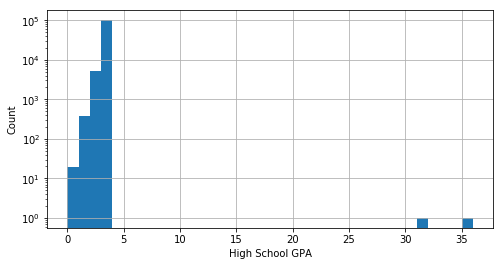

In [4]:
plt.figure(figsize=(8,4))
df_student.HSGPA.hist(bins=np.arange(0.01,37.01))
plt.xlabel('High School GPA'); plt.ylabel('Count')
plt.yscale('log', nonposy='clip')

#### Short Answer 1
The highest possible GPA is 4.0, but the above plot shows values above 30.
These values must be errors. Give at least two possible explanations for how a value of 31 could end up in a student's gpa record.

🤔 Your answer here:

### Clean Data
We can do some data cleaning to remove values that are obvious errors.

In [5]:
# Remove outliers
outliers = df_student.HSGPA > 4
df_student.loc[outliers] = None
# Remove missing data coded as 0
missing = df_student.HSGPA == 0
df_student.loc[missing] = None

#### Plot Cleaned Data

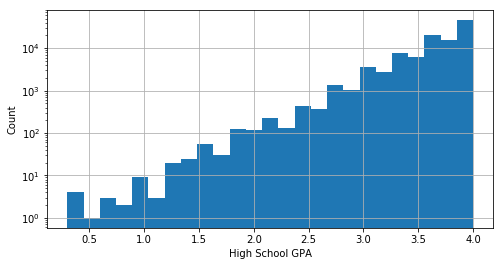

In [6]:
plt.figure(figsize=(8,4))
df_student.HSGPA.hist(bins=25)
plt.xlabel('High School GPA'); plt.ylabel('Count')
plt.yscale('log', nonposy='clip')

In [7]:
# More data cleaning

outliers = df_course.GRADE > 4
df_course.loc[outliers] = None
missing = np.isnan(df_course.GRADE)
df_course = df_course.dropna()

## 2.3 Combining Data
We can join the student and course data into a single data frame.

In [8]:
df_combined = df_course.join(df_student, on="ANONID")

## Section 3: Sampling
Often, data is collected from a small group in order to try to understand a larger group. For example, asking 100 random students to complete a survey in order to understand the entire student body. This process is called _sampling_. The data collected is called the ___sample___ and the larger group is the ___target population___.

In [9]:
# Helper functions

def get_bins(values):
    values = sorted(set(values))
    midpoints = [np.mean((values[i],values[i+1])) for i, g in enumerate(values[:-1])]
    left = values[0] - (midpoints[0] - values[0])
    right = values[-1] + (values[-1] - midpoints[-1])
    bins = [left] + midpoints + [right]
    return bins

grade_hist_bins = get_bins(df_course.GRADE)
all_grades = sorted(set(df_course.GRADE))

def get_sample_mean(df, num_samples=10):
    samples = df.GRADE.dropna().sample(num_samples, replace=True)
    return samples.mean()

def grade_hist(grades, color=(0,0,1,0.5)):
    n, bins, patches = plt.hist(grades, align="mid", bins=grade_hist_bins, width=0.1, color=color)
    plt.xticks(range(5), ['E', 'D', 'C', 'B', 'A'])
    plt.ylabel("Count")
    plt.xlabel("Grade")
    
def grade_stem(grades, color=(0,0,1,0.5)):
    bin_values, bins = np.histogram(grades, grade_hist_bins)
    plt.stem(all_grades, bin_values, basefmt="none")
    plt.xticks(range(5), ['E', 'D', 'C', 'B', 'A'])
    ylim = plt.ylim()
    plt.ylim([0, ylim[1]])
    plt.ylabel("Count")
    plt.xlabel("Grade")

def compare_populations(
        a, b,
        num_samples=10,
        num_experiments=1000,
        bins=20,
        rwidth=1,
        color=(0,0,1,0.5),
        confidence=None):
    a_mean = []
    pop_mean = b.GRADE.mean()
    for i in range(num_experiments):
        a_mean.append(get_sample_mean(a, num_samples))
    n, bins, patches = plt.hist(a_mean, bins=bins, rwidth=rwidth, color=color)
    plt.plot([pop_mean, pop_mean], [0, max(n)], "--", color="#7f7f7f")
    if confidence is not None:
        maxbin, maxcount = max(enumerate(n), key=lambda x: x[1])
        low = maxbin
        count = 1
        odd = False
        while sum(n[low:(low + count)]) < confidence * sum(n):
            lastlow = low
            lastcount = count
            if odd:
                high = low + count
                low = max(0, low - 1)
                count = high - low
                odd = False
            else:
                count = min(len(n) - low, count + 1)
                odd = True
        lowx = bins[lastlow]
        highx = bins[lastlow + lastcount]
        plt.plot([lowx, lowx], [0, max(n)], ":", color="#7f7f7f")
        plt.plot([highx, highx], [0, max(n)], ":", color="#7f7f7f")        
    plt.xticks(range(5), ['E', 'D', 'C', 'B', 'A'])
    plt.ylabel("Number of experiments")
    plt.legend()    

### 3.1 Sample Size

#### Population Mean
In this section, we will use the example of finding the mean course grade of students in the LARC data set. Since we have data on all students rather than just a sample, we can calculate the exact mean of all students, called the ___population mean___, but usually that's not possible. The cell below calculates the exact mean, which will be helpful to keep in mind throught this section.

In [10]:
pop_mean = df_course.GRADE.mean()
pop_mean

3.0570781394427815

#### Sampling
Now let's pretend we only have access to a sample and try to infer the mean of the population (all students) from the sample. The below cell simulates an experiment that samples three random course grades and calculates their mean, called the ___sample mean___. The figure shows the grades sampled and is labeled with the sample mean. You can repeat this cell to see different random samples.

Text(0.5,1,'Sample mean: 4.00')

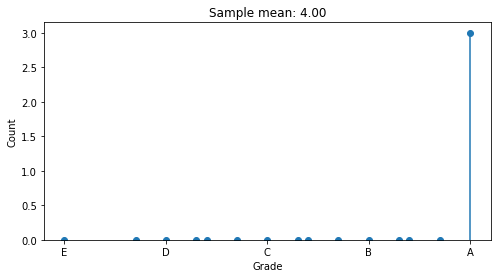

In [11]:
sample_size = 3
samples = df_course.GRADE.sample(sample_size)
plt.figure(figsize=(8,4))
grade_stem(samples)
plt.title("Sample mean: {:0.2f}".format(np.mean(samples)))

#### Sample Mean
The cell below re-samples 10 times and finds the mean of each sample.

In [12]:
means = []
for i in range(10):
    m = df_course.GRADE.sample(sample_size).mean()
    means.append(m)
    print("Sample {} mean: {:0.2f}".format(i ,m))
print("Sample mean range: {:0.2f} — {:0.2f}".format(min(means), max(means)))
print("Population mean: {:0.2f}".format(pop_mean))

Sample 0 mean: 3.23
Sample 1 mean: 3.53
Sample 2 mean: 2.67
Sample 3 mean: 3.57
Sample 4 mean: 3.90
Sample 5 mean: 1.90
Sample 6 mean: 2.90
Sample 7 mean: 3.77
Sample 8 mean: 2.33
Sample 9 mean: 3.43
Sample mean range: 1.90 — 3.90
Population mean: 3.06


#### Short Answer 2
What is the size of the range between the lowest and highest sample means?

Which letter grade or grades does this range correspond to?

🤔Your answer here:

#### Increasing Sample Size
Now, let's imagine you got a grant that allows you to sample a much larger number of students. The cell below samples 200 students to estimate the mean course grade.

Text(0.5,1,'Sample mean: 3.04')

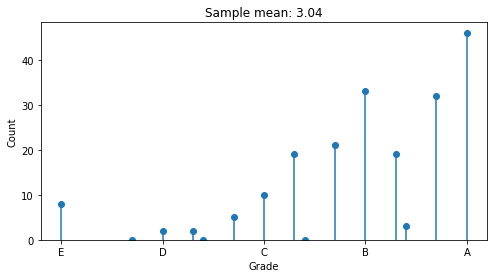

In [13]:
sample_size = 200
samples = df_course.GRADE.sample(sample_size)
plt.figure(figsize=(8,4))
grade_stem(samples)
plt.title("Sample mean: {:0.2f}".format(np.mean(samples)))

#### Repeated Measurements
Using the new sample size of 200, the below cell calculates the sample mean of 10 samples.

In [14]:
means = []
for i in range(10):
    m = df_course.GRADE.sample(sample_size).mean()
    means.append(m)
    print("Sample {} mean: {:0.2f}".format(i, m))
print("Range: {:0.2f} — {:0.2f}".format(min(means), max(means)))
print("Population mean: {:0.2f}".format(pop_mean))

Sample 0 mean: 2.96
Sample 1 mean: 3.06
Sample 2 mean: 3.13
Sample 3 mean: 3.12
Sample 4 mean: 3.12
Sample 5 mean: 2.90
Sample 6 mean: 3.13
Sample 7 mean: 2.99
Sample 8 mean: 3.11
Sample 9 mean: 3.02
Range: 2.90 — 3.13
Population mean: 3.06


#### Short Answer 3
What is the size of the range between the lowest and highest sample means?

How does sample size affect the range of sample means?

🤔Your answer here:

### 3.2 Sample Bias
In the previous section, we saw that estimates based on samples depend on the size of the sample. In this section, we explore what happens if a sample is drawn from a subset the population, rather than the entire population. For comparison, the cell below shows the true population mean of all course grades.

In [15]:
pop_mean

3.0570781394427815

#### Sampling Frame
The ___sampling frame___ is the set of possible samples. Ideally, the sampling frame should be the entire population, but that may not always be possible.

As an example, let's assume that we're conducting a survey of student grades and are sampling student names from SAT records. Not all students took the SAT. So it will not be possible to include students in the sample if they did not take the SAT. The cell below builds a data frame of students who have taken the SAT and then finds the sample mean 10 times using a sample size of 200.

In [16]:
df_sat = df_combined[df_combined.LAST_SATI_VERB_SCORE.isna() == False]
sample_size = 200
means = []
for i in range(10):
    m = df_sat.GRADE.sample(sample_size).mean()
    means.append(m)
    print("Sample {} mean: {:0.2f}".format(i, m))
print("Sample mean range: {:0.2f} — {:0.2f}".format(min(means), max(means)))
print("Population mean: {:0.2f}".format(pop_mean))

Sample 0 mean: 3.17
Sample 1 mean: 3.14
Sample 2 mean: 3.13
Sample 3 mean: 3.29
Sample 4 mean: 3.09
Sample 5 mean: 3.26
Sample 6 mean: 3.02
Sample 7 mean: 3.13
Sample 8 mean: 3.11
Sample 9 mean: 3.17
Sample mean range: 3.02 — 3.29
Population mean: 3.06


#### Short Answer 4
How does the range of sample means compare to the case where samples were drawn from all students? Consider both the size of the range and its center.

🤔Your answer here:

#### Increasing Sample Size
The above example showed that only sampling from students who have taken the SAT biases the sample mean to be higher than the population mean. Let's see if increasing the sample size helps at all. The below example chooses 10 random samples and calculates their means, this time including 5000 students in each sample.

In [17]:
sample_size = 5000
means = []
for i in range(10):
    m = df_sat.GRADE.sample(sample_size).mean()
    means.append(m)
    print("Sample {} mean: {:0.2f}".format(i, m))
print("Range: {:0.2f} — {:0.2f}".format(min(means), max(means)))
print("Population mean: {:0.2f}".format(pop_mean))

Sample 0 mean: 3.16
Sample 1 mean: 3.17
Sample 2 mean: 3.13
Sample 3 mean: 3.16
Sample 4 mean: 3.16
Sample 5 mean: 3.16
Sample 6 mean: 3.15
Sample 7 mean: 3.14
Sample 8 mean: 3.16
Sample 9 mean: 3.18
Range: 3.13 — 3.18
Population mean: 3.06


#### Short Answer 5
Does increasing the sample size improve the estimate of the population mean grade when the samples are only taken from students who completed the SAT?

Compared to students who did not take the SAT, why might students who have taken the SAT have a higher grade point average?

🤔Your answer here:

### 3.3 Correlations
One of the most common tasks in quantitative analysis is to determine whether a relationship exists between two variables. When it does, those variables are said to be ___correlated___.

One way to examine correlation is to plot the two variables against each other and look at the slope of the best fit line. A steep upward slope is called a positive correlation and means an increase in one variable usually corresponds to an increase in the other.

A steep downward slope is called a negative correlation and means an increase in one variable usually corresponds to a decrease in the other.

The cell below shows examples of various kinds of correlations.

In [18]:
def generate_data(r=0):
    covs = [[1, r], [r, 1]]
    x, y = np.random.multivariate_normal([0, 0], covs, 1000).T
    return x, y

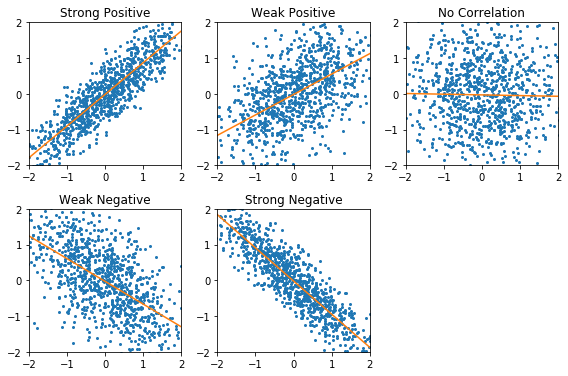

In [19]:
plt.figure(figsize=(8, 8 * 2/3))
parameters = [
    (0.9, 'Strong Positive'),
    (0.6, 'Weak Positive'),
    (0, 'No Correlation'),
    (-0.6, 'Weak Negative'),
    (-0.9, 'Strong Negative')
]
for i, (r, title) in enumerate(parameters):
    x, y = generate_data(r)
    plt.subplot(2, 3, i + 1)
    plt.plot(x, y, '.', markersize=4)
    plt.title(title)
    plt.xlim([-2, 2]); plt.ylim([-2, 2])
    m, b, r, p, se = spstats.linregress(x, y)
    plt.plot([min(x), max(x)], [min(x) * m + b, max(x) * m + b])
plt.tight_layout()

### 3.4 Spurious correlations
Correlations are a good indication that two variables are related, but are not always conclusive. If you measure a large number of variables and compare each one to the others, you will find some that correlate purely by chance. These are called ___spurious correlations___.

This section uses examples from Tyler Vigen's online directory of spurious correlations http://tylervigen.com/spurious-correlations. Each variable is a time series of 10 annual observations, such as the number of movies Nicolas Cage appeared in, or the number of Sociology PhDs awarded in the US.

In [20]:
# Helper functions

def show_correlation(pair):
    plt.figure(figsize=(4,4))
    p, r, a, b = pair
    df = a.join(b)
    x, y = [df[c] for c in df.columns]
    plt.figure(figsize=(4,4))
    plt.plot(x, y, '.', markersize=10)
    plt.xlabel(a.columns[0])
    plt.ylabel(b.columns[0])
    
def show_time_correlation(pair):
    fig, ax2 = plt.subplots(1,1, figsize=(8,4))
    p, r, a, b = pair
    df = a.join(b)
    x, y = [df[c] for c in df.columns]
    ax2.set_xlabel('Year')
    ax2.set_ylabel(a.columns[0])
    lns2 = ax2.plot(df.index, x, 'or-', label=df.columns[0])
    ax3 = ax2.twinx()
    ax3.set_ylabel(b.columns[0])
    lns3 = ax3.plot(df.index, y, 'sb-', label=df.columns[1])
    lns = lns2 + lns3
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=0)
    plt.tight_layout()
    
def plot_data(a):
    a = a.set_index('Year')
    fig, ax2 = plt.subplots(1,1, figsize=(8,4))
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Count')
    x = a[a.columns[0]]
    lns2 = ax2.plot(a.index, x, 'sb-', label=a.columns[0])
    lns = lns2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=0)
    plt.tight_layout()

def find_correlations(df):
    correlations = []
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            a = df[i].set_index('Year')
            b = df[j].set_index('Year')
            df_both = a.join(b)
            x, y = [df_both[c] for c in df_both.columns]
            r, p = spstats.pearsonr(x, y)
            if p < 0.05:
                correlations.append( (p, r, a, b))
    return sorted(correlations, key=lambda x: x[1], reverse=True)

In [21]:
data = [
    "data/cage.csv",
    "data/fall-pool.csv",
    "data/steam.csv",
    "data/bedsheets.csv",
    "data/sociology.csv",
    "data/cs.csv",
    "data/economics.csv",
    "data/anthropology.csv"]
df = [pd.read_csv(d) for d in data]

#### Visualize data
Now we can plot the various data sets.

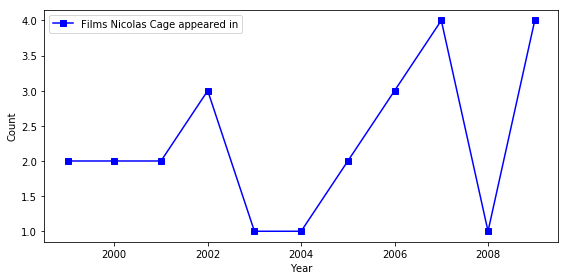

In [22]:
plot_data(df[0])

#### Finding Correlations
The following cell finds all pairs of data sets that are correlated with each other.

In [23]:
pairs = find_correlations(df)
for i, (p, r, a, b) in enumerate(pairs):
    print(i, ':', a.columns[0], '—', b.columns[0])

0 : Deaths by suffocating in bedsheets — Computer Science PhDs Awarded
1 : Computer Science PhDs Awarded — Economics PhDs Awarded
2 : Deaths by suffocating in bedsheets — Economics PhDs Awarded
3 : Films Nicolas Cage appeared in — Deaths by drowning after falling into swimming pool
4 : Murders by steam, hot vapors, or hot objects — Deaths by suffocating in bedsheets
5 : Murders by steam, hot vapors, or hot objects — Anthropology PhDs Awarded


#### Short Answer 6
There code above compares 8 data sets. There are 28 possible pairs of data sets. What fraction of these pairs are correlated?

🤔Your answer here:

#### Visualizing Correlation
The cells below visualize the correlation between variables in two different ways. The first plots one variable against the other. The next plots both variables over time.

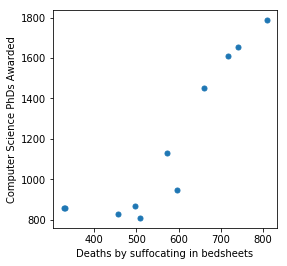

In [24]:
show_correlation(pairs[0])

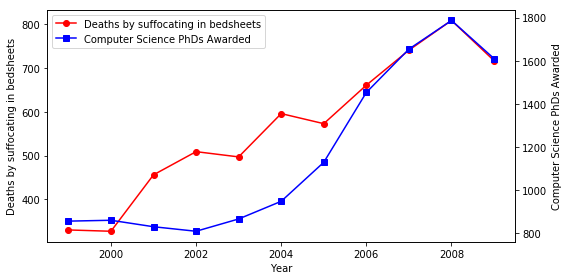

In [25]:
show_time_correlation(pairs[0])

## Section 4: Prediction
One common task in computational social science is to predict some feature of future data from data that has already been seen. This section will use the example of academic majors. Imagine you have access to the courses and grades of a group of students and want to determine what their current (or future) academic major is. This section will walk you through the process.

#### Subject grades
We will be predicting academic majors based on Grade Points Earned, the sum of all course grades a student has achieved (also called Michigan Honor Points at the University of Michigan).

Specifically, we will compare grade points earned within one subject (psychology) to grade points earned in other subjects. The cells below prepare the data by sorting it into psychology and non-psychology majors and producing a tuple of psychology and non-psychology grade points earned for each student.

In [26]:
# Helper function

def get_data_subject(df_combined, subject):
    df_a = df_combined[df_combined.MAJOR1_DESCR == subject]
    df_b = df_combined[df_combined.MAJOR1_DESCR != subject]
    return df_a, df_b

def extract_features_subject(df, subject):
    features = []
    df_indexed = df.groupby(['ANONID', 'SUBJECT']).sum()
    df_other = df[df.SUBJECT != subject].groupby('ANONID').sum()
    for anonid in set(df.ANONID):
        try:
            grade_a = df_indexed.loc[(anonid, subject)].GRADE
        except KeyError:
            grade_a = 0
        try:
            grade_b = df_other.loc[anonid].GRADE
        except KeyError:
            grade_b = 0
        features.append( (grade_a, grade_b) )
    return features

In [27]:
# Get data frames of psychology majors and other majors
df_psych, df_other = get_data_subject(df_combined, "Psychology BA")
# Convert data frames into features
features_psych = extract_features_subject(df_psych, "PSYCH")[0:5000]
features_other = extract_features_subject(df_other, "PSYCH")[0:5000]

### 4.1 Visualize
The cell below visualizes these data.

Text(0,0.5,'Grade Points Earned: Non-Psychology')

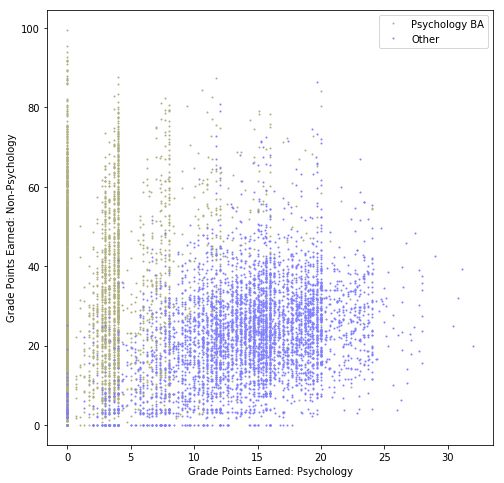

In [28]:
plt.figure(figsize=(8,8))
x, y = zip(*features_other)
plt.plot(x, y, 'o', markersize=1, color="#AFAF7F", label="Psychology BA")
x, y = zip(*features_psych)
plt.plot(x, y, 'o', markersize=1, color="#7F7FFF", label="Other")
plt.legend()
plt.xlabel("Grade Points Earned: Psychology")
plt.ylabel("Grade Points Earned: Non-Psychology")

#### Short Answer 7
Looking at the above figure, how would you predict the major of student from their grade points earned?

🤔Your answer here:

### 4.2 Features
The cell below combines the features for all students into a single list, and the corresponding academic major labels for students into another. These are the lists that will be used to predict academic majors and test our predictions.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
import random
X = features_psych + features_other
y = ["Psych"] * len(features_psych) + ["Other"] * len(features_other)
print("Feature:", X[0])
print("Label:", y[0])

Feature: (13.800000000000001, 31.099999999999998)
Label: Psych


### 4.3 Classifiers
Now we will create a ___classifier___ to make predictions based on the features we have created. We first give the classifier a set of features with known labels, called training data. The classifier will use this to make future predictions.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95)
classifier = SVC(kernel="linear", probability=True)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Testing The Classifier
The below cell picks a random feature (student) and predicts their label (academic major) using the classifier. It also prints out the correct academic major so we can see whether we were correct.

In [31]:
i = random.randint(0, len(X_test) - 1)
sample = X_test[i]
prediction = classifier.predict([sample])
true = y_test[i]
print("Psych grade points:", sample[0])
print("Other grade points:", sample[1])
print("Predicted:\t", prediction[0])
print("True:\t\t", true)

Psych grade points: 0
Other grade points: 38.8
Predicted:	 Other
True:		 Other


#### Short Answer
Run the above cell several times. When the classifier makes a mistake, is it usually predicting a student is a psychology major when they truly aren't? Or predicting other majors for true psychology majors? Or is it about 50/50?

🤔Your answer here:

### 4.4 Precision and Recall

There are two ways to measure the quality of a classifier, based on the two types of errors it can make. Using psychology classes as an example, with a high ___precision___ classifier, you can be confident sample labeled as psychology is truly a psychology major. With a high ___recall___ classifier, you can be confident that nearly all of the psychology majors were detected. Most classifiers have a ___threshold___ that can be changed to alter the precision and recall. The cell below shows how the precision and recall varies with the threshold

In [33]:
# Helper function

def get_precision_recall(X, y, threshold, test_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    classifier = SVC(kernel="linear", probability=True)
    classifier.fit(X_train, y_train)
    y_pred_proba = classifier.predict_proba(X_test)
    y_pred = ['Psych' if x[1] > threshold else 'Other' for x in y_pred_proba]
    precision = precision_score(y_test, y_pred, pos_label='Psych')
    recall = recall_score(y_test, y_pred, pos_label='Psych')
    return precision, recall

100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


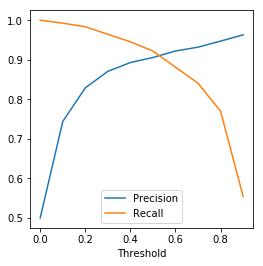

In [34]:
precision = []
recall = []
thresholds = []
for threshold in tqdm([x / 10 for x in range(10)]):
    p, r = get_precision_recall(X, y, threshold=threshold, test_size=0.95)
    if p < 0.01 and r < 0.01:
        continue
    thresholds.append(threshold)
    precision.append(p)
    recall.append(r)
plt.figure(figsize=(4,4))
plt.plot(thresholds, precision, label="Precision")
plt.plot(thresholds, recall, label="Recall")
plt.xlabel("Threshold");
plt.legend()

#### Short Answer 8
Depending on the application, sometimes precision is more desirable and sometimes recall is more desirable. For example, if you were using a classifier to find likely locations of a rare lost treasure, you would want a high recall, to make sure you didn't miss possible locations.

Can you think of one example where recall is more important and one where precision is more important? Explain your reasoning.

🤔Your answer here:

#### F1 Score
It can be confusing to consider two separate measures of quality, so they are often combined into a single measure called the ___F1 score___. The cell below shows how F1 score changes along with precision and recall.

Weight	Prec.	Recall	F1


Text(0.5,0,'Threshod')

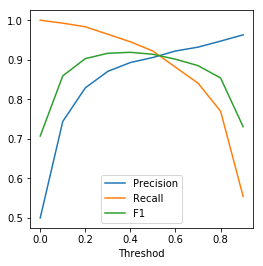

In [35]:
print("Weight\tPrec.\tRecall\tF1")
f1 = [math.sqrt(precision[i] * recall[i]) for i in range(len(thresholds))]
plt.figure(figsize=(4,4))
plt.plot(thresholds, precision, label="Precision")
plt.plot(thresholds, recall, label="Recall")
plt.plot(thresholds, f1, label="F1")
plt.legend()
plt.xlabel('Threshod')

## Validation

In [36]:
# Test with training data
X_train = random.sample(features_psych, 2) + random.sample(features_other, 2)
y_train = ["Psych"] * 2 + ["Other"] * 2
classifier = SVC(kernel="linear")
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [37]:
y_pred = classifier.predict(X_train)
f1_score(y_train, y_pred, pos_label='Psych')

1.0

In [38]:
# Test with out-of-sample data
X_test = random.sample(features_psych, 50) + random.sample(features_other, 50)
y_test = ["Psych"] * 50 + ["Other"] * 50
y_pred = classifier.predict(X_test)
f1_score(y_test, y_pred, pos_label='Psych')

0.74999999999999989

## Reflection

#### Reflection Question 1

Consider a course where every student completing the course got an A. From only this information would you conclude that it would be easy to get an A in this class?

The student performance data doesn't contain grades for students who withdrew from a course without completing it. Now, you learn that 75% of the students dropped the class after failing the midterm. Does that change your answer to the above question?

Assuming that students only withdraw when they are performing poorly, how does the exclusion of students who have withdrawn from courses change the apparent student performance in a class?

🤔Your answer here:

#### Reflection Question 2
In the first section of this lab, we saw that increasing the sample size decreased the range, or ___variance___, of estimates. We also saw that systematically excluding a group of indidividuals from the sample can raise or lower the entire range, called ___bias___.

Can you think of an example where it is most important to reduce the variance, possibly at the expense of increasing bias?

Can you think of an example where it is most important to reduce bias, possibly at the expense of increasing variance?

🤔Your answer here:

#### Reflection Question 3
Usually, the more data you use to train a classifier, the more accurate it will be. However, the less data you will have avaialbe to test on.

What is the advantage of using a large amount of training data?

What is the advantage of using a large amount of test data?

🤔Your answer here:

#### Reflection Question 4
Over the past decades, ___grade inflation___ has caused average course grades to steadily increase at many universites. Imagine you are using historical data to predict a current student's performance.

How, if at all, could grade inflation increase the variance of the prediction?

How, if at all, could grade inflation increase the bias of the prediction?

🤔Your answer here:

## References

Matz, R. L., Koester, B. P., Fiorini, S., Grom, G., Shepard, L., Stangor, C. G., ... & McKay, T. A. (2017). Patterns of Gendered Performance Differences in Large Introductory Courses at Five Research Universities. AERA Open, 3(4), 2332858417743754.

Wright, M. C., McKay, T., Hershock, C., Miller, K., & Tritz, J. (2014). Better than expected: Using learning analytics to promote student success in gateway science. Change: The Magazine of Higher Learning, 46(1), 28-34.